## Image classification model with very little data
from this [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

In [2]:
import glob
import numpy as np
import cv2
import matplotlib

%matplotlib inline

In [1]:
from keras.preprocessing import image as image_utils #????
# from imagenet_utils import decode_predictions
# from imagenet_utils import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


Objectives:
- train small network from scratch (as baseline)
- use bottleneck features of pre-trained network
- fine-tune top layers of pre-trained network

Keras features to cover:
- `fit_generator` (for training model using python data generators)
- `ImageDataGenerator` (for real-time data augmentation)
- layer freezing and model fine-tuning

Setup:
- Keras, SciPy, PIL installed
- NVIDIA GPU (with cuDNN installed) is nice (but not neccessary on small image set)
- training + validation data directories with one subdirectly per image class (png or jpg)

Deep learning on small-data problems:
- deep learning requires learning features automatically from data, generally only possible when lots of training data is available esp where input samples are very high-dimensional like images
- but convolutional neural networks one of best models for "perceptual problems" such as image classification even with little data to learn from
- training convnets from scrath on small image dataset will still yield reasonable results
- deep learning models are highly repurposable - you can take an image classification trained on large-scale data then reuse it on significantly different problem
- many pre-trained models (usually trained on ImageNet dataset) can be use to bootstrap powerful vision models out of very little data 

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

one epoch = one forward pass and one backward pass of all the training examples
batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [5]:
#path to images
train_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/train/'
validation_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/validation'

#model paramter setup
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 50

In [9]:
#instantiate moel
model = Sequential()

### stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

dim_ordering: One of {"th", "tf"}. "tf" mode means that the images should have shape (samples, width, height, channels), "th" mode means that the images should have shape (samples, channels, width, height). It defaults to the image_dim_ordering value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "tf".

In [342]:
# Because you're using tensorflow you have to put the "depth" as the 3rd dimension.
# Apparently for theano the depth comes first like in tutorial (3, 150, 150)
# and in tensorflow it comes last like (150, 150, 3)
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

Exception: Input 0 is incompatible with layer convolution2d_14: expected ndim=4, found ndim=2

In [345]:
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

Exception: Input 0 is incompatible with layer convolution2d_16: expected ndim=4, found ndim=2

In [12]:
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### plus two fully-connected layers
We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification.

In [13]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

In [14]:
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [331]:
#weights from the 32 filters in the convolution layer
#shouldn't this be 32 3x3 arrays?
model.layers[0].get_weights()[0].shape

(3, 3, 3, 32)

In [319]:
model.layers[0].get_weights()

[array([[[[ -4.67460454e-02,  -4.34178449e-02,  -3.56573947e-02,
            -5.46074510e-02,  -2.65653338e-02,  -1.07214034e-01,
             1.09303789e-02,   6.90273941e-02,   5.15009742e-03,
             1.82390828e-02,   6.59697428e-02,  -9.13613662e-02,
             7.97450691e-02,   6.21020868e-02,   2.37962026e-02,
            -1.15647718e-01,   4.92916368e-02,   6.41750395e-02,
            -8.39228928e-03,  -8.79368559e-02,  -8.99464488e-02,
            -2.19070017e-02,  -5.17265350e-02,   3.96898873e-02,
            -2.74475608e-02,   2.18247771e-02,  -7.77575895e-02,
            -4.42245863e-02,  -3.13317701e-02,  -7.37711266e-02,
            -1.89550817e-02,  -1.45828826e-02],
          [  1.13925718e-01,  -2.08417187e-04,   1.15419075e-01,
            -5.06427884e-02,  -2.97603440e-02,  -9.38137770e-02,
             8.20157602e-02,  -1.04650490e-01,   1.09315753e-01,
             7.60036930e-02,   2.58783288e-02,  -4.29882593e-02,
            -1.05069101e-01,  -6.35446385e

In [270]:
import keras.backend as K

# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])


NameError: name 'convout1' is not defined

### prepare data
use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

### rescale
- value by which you mulitply the data before any other processing
- original image RGB coefficients 0-255 but these values are too high for our models to process (given a typical learning rate) so target values between 0-1 by scalling with a 1/255 factor

In [244]:
# this is the augmentation configuration we will use for training

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [17]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [242]:
# does this actually create additional images? if so how many and how can you control that... 
# see image processing keras notebook for example of .flow creating additional images

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary',
        save_to_dir='/Users/VanessaG/Desktop/image_gen_test',
        save_format='jpg')

Found 2000 images belonging to 2 classes.


In [243]:
for i, (image, y) in enumerate(train_generator):
    if i >= 10:
        break

In [22]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 800 images belonging to 2 classes.


### use these generators to train model
Fits the model on data generated batch-by-batch by a Python generator. The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.



In [31]:
pizza_model = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/50
2000/2000 [==============================] - 79s - loss: 0.6744 - acc: 0.5965 - val_loss: 0.6215 - val_acc: 0.6525
Epoch 2/50
2000/2000 [==============================] - 73s - loss: 0.6228 - acc: 0.6775 - val_loss: 0.5397 - val_acc: 0.7238
Epoch 3/50
2000/2000 [==============================] - 73s - loss: 0.5900 - acc: 0.7110 - val_loss: 0.5350 - val_acc: 0.7712
Epoch 4/50
2000/2000 [==============================] - 73s - loss: 0.5570 - acc: 0.7390 - val_loss: 0.5325 - val_acc: 0.7350
Epoch 5/50
2000/2000 [==============================] - 74s - loss: 0.5414 - acc: 0.7410 - val_loss: 0.7256 - val_acc: 0.5625
Epoch 6/50
2000/2000 [==============================] - 73s - loss: 0.5407 - acc: 0.7380 - val_loss: 0.5973 - val_acc: 0.6713
Epoch 7/50
2000/2000 [==============================] - 74s - loss: 0.5136 - acc: 0.7615 - val_loss: 0.4852 - val_acc: 0.7750
Epoch 8/50
2000/2000 [==============================] - 74s - loss: 0.5182 - acc: 0.7495 - val_loss: 0.4416 - val_acc:

## Model stats

In [67]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 148, 148, 32)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 148, 148, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 74, 74, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 72, 72, 32)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [59]:
model.get_config()[:3]

[{'class_name': 'Convolution2D',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'batch_input_shape': (None, 150, 150, 3),
   'bias': True,
   'border_mode': 'valid',
   'dim_ordering': 'tf',
   'init': 'glorot_uniform',
   'input_dtype': 'float32',
   'name': 'convolution2d_1',
   'nb_col': 3,
   'nb_filter': 32,
   'nb_row': 3,
   'subsample': (1, 1),
   'trainable': True}},
 {'class_name': 'Activation',
  'config': {'activation': 'relu', 'name': 'activation_1', 'trainable': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'border_mode': 'valid',
   'dim_ordering': 'tf',
   'name': 'maxpooling2d_1',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}}]

In [32]:
model.save_weights('/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/keras_pizza_model.h5')

## Evaluate model results

To estimate the ability of your model to generalize to new data (which is probably what you want to do), then you look at the validation accuracy, because the validation split contains only data that the model never sees during the training and therefore cannot just memorize. In practice, the training loss can drop significantly due to over-fitting, which is why you want to look at validation loss.

If your training data accuracy ("acc") keeps improving while your validation data accuracy ("val_acc") gets worse, you are likely in an overfitting situation, i.e. your model starts to basically just memorize the data.

Each epoch is a training run over all of your data. During that run the parameters of your model are adjusted according to your loss function. The result is a set of parameters which have a certain ability to generalize to new data. That ability is reflected by the validation accuracy. So think of every epoch as its own model, which can get better or worse if it is trained for another epoch. Whether it got better or worse is judged by the change in validation accuracy (better = validation accuracy increased). Therefore pick the model of the epoch with the highest validation accuracy. Don't average the accuracies over different epochs, that wouldn't make much sense. You can use the Keras callback ModelCheckpoint to automatically save the model with the highest validation accuracy (see callbacks documentation).

Keras provides the capability to register callbacks when training a deep learning model.

One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics for each epoch. This includes the loss and the accuracy (for classification problems) as well as the loss and accuracy for the validation dataset, if one is set.

In [162]:
pizza_model.epoch[:5]

[0, 1, 2, 3, 4]

In [40]:
#why is there an accuracy measure on training data?
#also still unclear what loss is exactly - 
pizza_model.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

In [167]:
pizza_model.history['val_acc'][:5]

[0.65249999999999997,
 0.72375,
 0.77124999999999999,
 0.73499999999999999,
 0.5625]

What plots can show
It’s speed of convergence over epochs (slope).
Whether the model may have already converged (plateau of the line).
Whether the mode may be over-learning the training data (inflection for validation line).

From the plot of accuracy we can see that the model could probably be trained a little more as the trend for accuracy on both datasets is still rising for the last few epochs. We can also see that the model has not yet over-learned the training dataset, showing comparable skill on both datasets

From the plot of loss, we can see that the model has comparable performance on both train and validation datasets (labeled test). If these parallel plots start to depart consistently, it might be a sign to stop training at an earlier epoch.



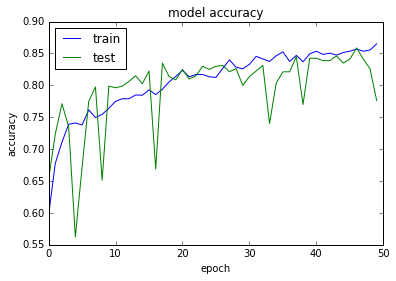

In [94]:
# summarize history for accuracy
# A plot of accuracy on the training and validation datasets over training epochs.
plt.plot(pizza_model.history['acc'])
plt.plot(pizza_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

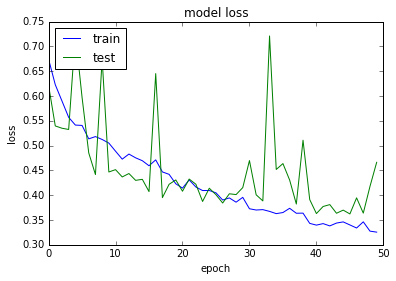

In [96]:
# summarize history for loss
# A plot of loss on the training and validation datasets over training epochs.

plt.plot(pizza_model.history['loss'])
plt.plot(pizza_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
np.mean(pizza_model.history['acc'])

0.80617000000000005

In [154]:
np.mean(pizza_model.history['val_acc'])

0.79552499999999993

In [71]:
model.metrics_names

['loss', 'acc']

In [98]:
#why is this different from np.mean(pizza_model.history['acc])
model.evaluate_generator(validation_generator, nb_validation_samples, max_q_size=10,
                         nb_worker=1)

[0.46632025957107542, 0.77625]

In [99]:
predictions = model.predict_generator(validation_generator, nb_validation_samples,
                                      max_q_size=10, nb_worker=1, pickle_safe=False)


In [100]:
predictions[0:10]

array([[ 0.99510431],
       [ 0.22117342],
       [ 0.91974723],
       [ 0.98205471],
       [ 0.31657547],
       [ 0.90518534],
       [ 0.73111486],
       [ 0.96756828],
       [ 0.85108924],
       [ 0.46803811]], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126a73c10>]], dtype=object)

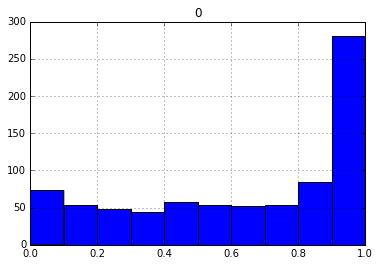

In [102]:
import pandas as pd
%matplotlib inline
preds = pd.DataFrame(predictions)
preds.hist()

In [103]:
validation_generator.class_indices

{'not_pizza': 0, 'pizza': 1}

In [104]:
validation_generator_2 = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary',
        shuffle=False)

Found 800 images belonging to 2 classes.


In [75]:
pizzas = glob.glob(validation_data_dir+'/pizza/*.jpg')
not_pizzas = glob.glob(validation_data_dir+'/not_pizza/*.jpg')
print len(pizzas), len(not_pizzas)

400 400


In [105]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator_2):
    if i >= 800:
        break
    pp = model.predict(img)
    label = int(pp[0] >= 0.5)
    predictions.append(pp[0][0])
    predicted_labels.append(label)
    

In [106]:
print predictions[0:10]
print predicted_labels[0:10]

[0.01505492, 0.2494195, 0.48538959, 0.17214279, 0.70707059, 0.53252172, 0.95420098, 0.36732924, 0.92302752, 0.14975837]
[0, 0, 0, 0, 1, 1, 1, 0, 1, 0]


In [130]:
## 801?
len(predicted_labels), len(predictions) 

(801, 801)

In [107]:
np.mean([1 if pl == l 
         else 0 for pl, l 
         in zip(predicted_labels, np.zeros(400).tolist()+np.ones(400).tolist())])

0.77625

In [80]:
image_file_predictions = {}
for i, filename in enumerate(not_pizzas+pizzas):
    image_file_predictions[filename] = {
        'predicted_class':predicted_labels[i],
        'predicted_prob_pizza':predictions[i]
    }

In [146]:
image_file_df = pd.DataFrame(image_file_predictions)

In [147]:
image_file_df.T.head()

,predicted_class,predicted_prob_pizza
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1006400.jpg,0.0,0.015055
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1010547.jpg,0.0,0.249419
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1026621.jpg,0.0,0.485390
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/102854.jpg,0.0,0.172143
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1053345.jpg,1.0,0.707071


In [148]:
image_file_df = image_file_df.T
image_file_df = image_file_df.reset_index()
image_file_df.shape

(800, 3)

In [149]:
image_file_df.head()

,index,predicted_class,predicted_prob_pizza
0,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.015055
1,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.249419
2,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.485390
3,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.172143
4,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.707071


In [150]:
image_file_df.columns = ['filepath','predicted_class','predicted_prob_pizza']
image_file_df['actual_label'] = image_file_df.filepath.map(lambda x: 0 if '/not_pizza/' in x else 1)
image_file_df.head(20)

,filepath,predicted_class,predicted_prob_pizza,actual_label
0,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.015055,0
1,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.249419,0
2,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.485390,0
3,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.172143,0
4,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.707071,0
5,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.532522,0
6,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.954201,0
7,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.367329,0
8,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.923028,0
9,/Users/VanessaG/Desktop/pizza_class_data/valid...,0.0,0.149758,0


In [180]:
# i want to plot the ones it classifies wrong that have the highest probability
# and the ones that are right & the highest probability

In [211]:
worst_predictions = image_file_df[(image_file_df.predicted_class == 1.00) & 
              (image_file_df.actual_label == 0)].sort_values('predicted_prob_pizza', ascending=False).head(8)

In [212]:
worst_predictions

,filepath,predicted_class,predicted_prob_pizza,actual_label
103,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.997879,0
29,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.992875,0
16,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.988491,0
263,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.987966,0
147,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.984841,0
116,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.983097,0
235,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.970130,0
266,/Users/VanessaG/Desktop/pizza_class_data/valid...,1.0,0.959904,0


In [213]:
worst_pred_pics = list(worst_predictions['filepath'])


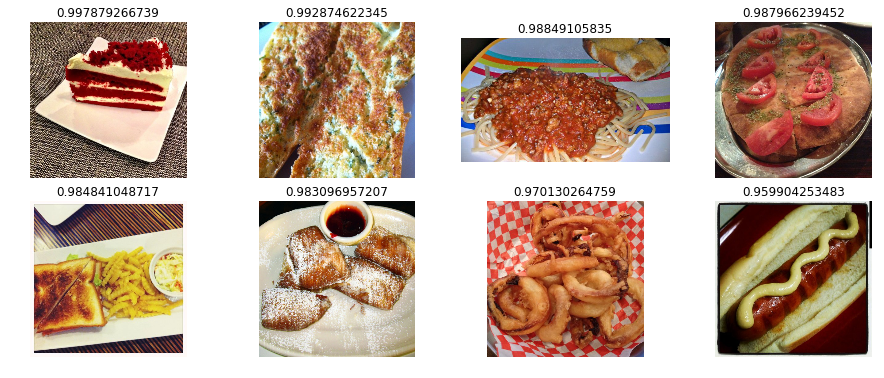

In [229]:
fig, ax = plt.subplots(2,4,figsize=(16,6))
fig.subplots_adjust(hspace=0.15, wspace=0.1)
images = []

for img in worst_pred_pics:
    image = load_img(img)
    images.append(image)
    
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")
    #plt.xlabel("test")
    plt.title(worst_predictions.iloc[i, 2])

In [199]:
best_predictions = image_file_df[(image_file_df.predicted_class == 1.00) & 
              (image_file_df.actual_label == 1)].sort_values('predicted_prob_pizza', ascending=False).head(8)

In [206]:
best_pred_pics = list(best_predictions['filepath'])

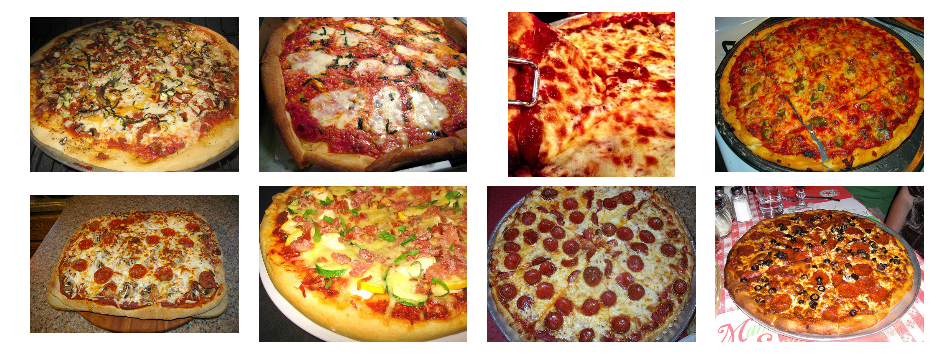

In [207]:
fig, ax = plt.subplots(2,4,figsize=(16,6))
fig.subplots_adjust(hspace=0.025, wspace=0.1)
images = []
for img in best_pred_pics:
    image = load_img(img)
    images.append(image)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")

In [151]:
image_file_df.actual_label.value_counts()

1    400
0    400
Name: actual_label, dtype: int64

In [131]:
actual_labels = list(validation_generator_2.classes)

In [132]:
len(actual_labels)

800

In [135]:
actual_labels[0:5]

[0, 0, 0, 0, 0]

In [153]:
from sklearn.metrics import classification_report
print(classification_report(image_file_df['actual_label'], image_file_df['predicted_class']))

             precision    recall  f1-score   support

          0       0.90      0.62      0.73       400
          1       0.71      0.93      0.81       400

avg / total       0.81      0.78      0.77       800



The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

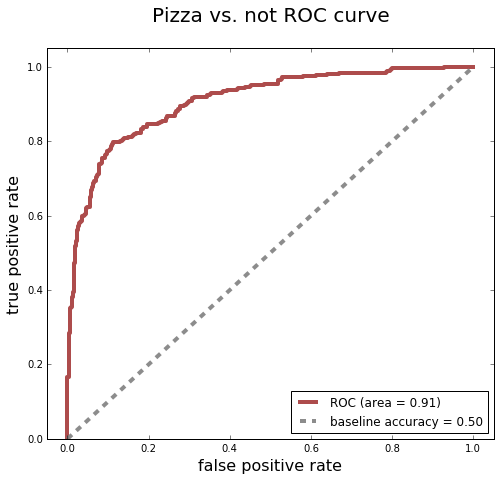

In [231]:
#how to change threshold?
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_, tpr_, _ = roc_curve(image_file_df['actual_label'], image_file_df['predicted_prob_pizza'])
auc_ = auc(fpr_, tpr_)
acc_ = np.abs(0.5 - np.mean(image_file_df['actual_label'])) + 0.5

fig, axr = plt.subplots(figsize=(8,7))

axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
         color='darkred', linewidth=4,
         alpha=0.7)
axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
         alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

axr.set_xlim([-0.05, 1.05])
axr.set_ylim([0.0, 1.05])
axr.set_xlabel('false positive rate', fontsize=16)
axr.set_ylabel('true positive rate', fontsize=16)
axr.set_title('Pizza vs. not ROC curve\n', fontsize=20)

axr.legend(loc="lower right", fontsize=12)

plt.show()

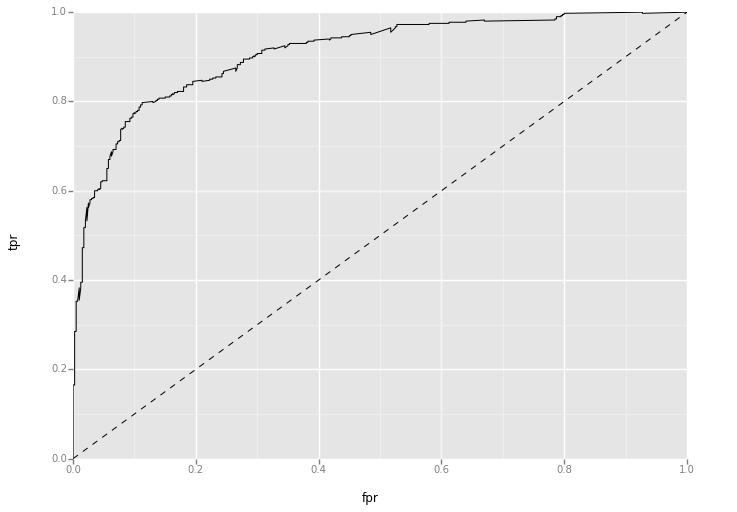

<ggplot: (308673597)>

In [170]:
from sklearn import metrics
from ggplot import *

# preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(image_file_df['actual_label'], image_file_df['predicted_prob_pizza'])

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

In [232]:
df.head()

,fpr,tpr
0,0.0000,0.0025
1,0.0000,0.0850
2,0.0000,0.0900
3,0.0000,0.1650
4,0.0025,0.1650


In [237]:
auc = metrics.auc(fpr, tpr)
ggplot(df, aes(x='fpr', ymin=0, ymax='tpr')) #+\
    #geom_line(aes(y='tpr')) #+\
    #geom_area(alpha=0.2) +\
    
    #ggtitle("ROC Curve w/ AUC=%s" % str(auc))

TypeError: 'int' object is not iterable

In [111]:
#not as cool as i thought
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')